In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import re
import seaborn as sns
import spacy

from glob import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

tqdm.pandas()

# Dicionário de dados

O dataset de treino possui as seguintes colunas:  
- userId: id do usuário  
- userType: usuário logado ou anônimo  
- HistorySize: quantidade de notícias lidas pelo usuário  
- history: lista de notícias visitadas pelo usuário  
- TimestampHistory: momento em que o usuário visitou a página  
- timeOnPageHistory: quantidade de ms em que o usuário ficou na página  
- numberOfClicksHistory: quantidade de clicks na matéria  
- scrollPercentageHistory: quanto o usuário visualizou da matéria  
- pageVisitsCountHistory: quantidade de vezes que o usuário visitou a matéria  

Do dataset itens, que é um complemento do dataset do treino, tem a seguinte informação:  
- Page: id da matéria. Esse é o mesmo id que aparece na coluna history de antes.  
- Url: url da matéria  
- Issued: data em que a matéria foi criada  
- Modified: última data em que a matéria foi modificada  
- Title: título da matéria  
- Body: corpo da matéria  
- Caption: subtítulo da matéria  

# Importação do dataset

In [2]:
count = []
arquivos_treino = glob('./files/treino/*.csv')
for arquivo in arquivos_treino:
    df = pd.read_csv(arquivo)
    count.append(df.count())
del(df)

print(pd.DataFrame(count).T)

                              0       1       2       3       4      5
userId                   100000  100000  100000  100000  100000  77942
userType                 100000  100000  100000  100000  100000  77942
historySize              100000  100000  100000  100000  100000  77942
history                  100000  100000  100000  100000  100000  77942
timestampHistory         100000  100000  100000  100000  100000  77942
numberOfClicksHistory    100000  100000  100000  100000  100000  77942
timeOnPageHistory        100000  100000  100000  100000  100000  77942
scrollPercentageHistory  100000  100000  100000  100000  100000  77942
pageVisitsCountHistory   100000  100000  100000  100000  100000  77942
timestampHistory_new     100000  100000  100000  100000  100000  77942


In [3]:
count = []
arquivos_itens = glob('./itens/itens/*.csv')
for arquivo in arquivos_itens:
    df = pd.read_csv(arquivo)
    count.append(df.count())
del(df)

print(pd.DataFrame(count).T)

               0       1      2
page      100000  100000  55603
url       100000  100000  55603
issued    100000  100000  55603
modified  100000  100000  55603
title     100000  100000  55603
body      100000  100000  55603
caption   100000  100000  55603


In [4]:
treino_df = pd.concat([pd.read_csv(arquivo) for arquivo in arquivos_treino], ignore_index=True)
itens_df = pd.concat([pd.read_csv(arquivo) for arquivo in arquivos_itens], ignore_index=True)

# EDA

In [5]:
treino_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577942 entries, 0 to 577941
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   userId                   577942 non-null  object
 1   userType                 577942 non-null  object
 2   historySize              577942 non-null  int64 
 3   history                  577942 non-null  object
 4   timestampHistory         577942 non-null  object
 5   numberOfClicksHistory    577942 non-null  object
 6   timeOnPageHistory        577942 non-null  object
 7   scrollPercentageHistory  577942 non-null  object
 8   pageVisitsCountHistory   577942 non-null  object
 9   timestampHistory_new     577942 non-null  object
dtypes: int64(1), object(9)
memory usage: 44.1+ MB


In [6]:
itens_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255603 entries, 0 to 255602
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   page      255603 non-null  object
 1   url       255603 non-null  object
 2   issued    255603 non-null  object
 3   modified  255603 non-null  object
 4   title     255603 non-null  object
 5   body      255603 non-null  object
 6   caption   255603 non-null  object
dtypes: object(7)
memory usage: 13.7+ MB


In [11]:
treino_df.head()

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new
0,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,"c8aab885-433d-4e46-8066-479f40ba7fb2, 68d2039c...","1657146417045, 1657146605778, 1657146698738","76, 38, 41","20380, 21184, 35438","50.3, 18.18, 16.46","2, 1, 1","1657146417045, 1657146605778, 1657146698738"
1,2c1080975e257ed630e26679edbe4d5c850c65f3e09f65...,Non-Logged,60,"3325b5a1-979a-4cb3-82b6-63905c9edbe8, fe856057...","1656684240278, 1656761266729, 1656761528085, 1...","7, 80, 2, 1, 7, 62, 26, 44, 4, 4, 14, 45, 13, ...","6049, 210489, 8672, 10000, 30000, 123007, 9965...","25.35, 45.66, 35.3, 28.05, 36.53, 47.57, 55.33...","1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1...","1656684240278, 1656761266729, 1656761528085, 1..."
2,0adffd7450d3b9840d8c6215f0569ad942e782fb19b805...,Logged,107,"04756569-593e-4133-a95a-83d35d43dbbd, 29b6b142...","1656678946256, 1656701076495, 1656701882565, 1...","0, 0, 0, 0, 0, 44, 0, 0, 2, 1, 0, 0, 0, 44, 0,...","311274, 140000, 32515, 157018, 118689, 159243,...","67.58, 47.22, 41.52, 63.09, 51.38, 65.11, 71.9...","1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1...","1656678946256, 1656701076495, 1656701882565, 1..."
3,c1e8d644329a78ea1f994292db624c57980b2886cfbc2d...,Non-Logged,56,"1f2b9c2f-a2d2-4192-b009-09065da8ec23, 04756569...","1658333312180, 1658404553818, 1658408449062, 1...","8, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1...","182696, 91925, 30000, 273655, 126409, 42980, 1...","58.26, 72.66, 22.57, 59.89, 40.36, 36.35, 14.7...","1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","1658333312180, 1658404553818, 1658408449062, 1..."
4,e777d1f31d4d955b63d60acc13df336d3903f52ab8f8f4...,Non-Logged,4,"bebdeb3e-1699-43e0-a1b8-989f5a6ab679, f4b484a7...","1658766608801, 1658766608801, 1660084035094, 1...","579, 579, 7, 2","801396, 801396, 10000, 10000","78.74, 78.74, 16.71, 9.34","7, 7, 1, 1","1658766608801, 1658766608801, 1660084035094, 1..."


In [12]:
itens_df.head()

,page,url,issued,modified,title,body,caption
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic..."


In [70]:
print("quantidade de dados duplicados: ",treino_df.duplicated().sum())

quantidade de dados duplicados:  0


In [72]:
print("quantidade de usuários: ", treino_df['userId'].nunique())

quantidade de usuários:  577942


In [78]:
print("quantidade de tipos de usuários: ", treino_df['userType'].nunique())
print("proporção de tipos de usuários: \n", (treino_df['userType'].value_counts(normalize=True)*100).to_frame())

quantidade de tipos de usuários:  2
proporção de tipos de usuários: 
             proportion
userType              
Non-Logged       79.39
Logged           20.61


In [79]:
print("quantidade de páginas duplicadas: ", itens_df.duplicated().sum())

quantidade de páginas duplicadas:  0


In [80]:
print("quantidade de páginas: ",itens_df['page'].nunique())

quantidade de páginas:  255603


In [7]:
historico = [
    'history',
    'timestampHistory',
    'numberOfClicksHistory',
    'timeOnPageHistory',
    'scrollPercentageHistory',
    'pageVisitsCountHistory',
    'timestampHistory_new'
]

logs_df = treino_df.copy()
del(treino_df)
for coluna in historico:
    logs_df[coluna] = logs_df[coluna].apply(lambda x: str(x).split(", "))
logs_df = logs_df.explode(historico, ignore_index=True)
logs_df.isnull().sum()

userId                     0
userType                   0
historySize                0
history                    0
timestampHistory           0
numberOfClicksHistory      0
timeOnPageHistory          0
scrollPercentageHistory    0
pageVisitsCountHistory     0
timestampHistory_new       0
dtype: int64

In [14]:
logs_df.shape

(8123951, 10)

In [15]:
logs_df.head()

,userId,userType,historySize,history,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new
0,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,c8aab885-433d-4e46-8066-479f40ba7fb2,1657146417045,76,20380,50.3,2,1657146417045
1,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,68d2039c-c9aa-456c-ac33-9b2e8677fba7,1657146605778,38,21184,18.18,1,1657146605778
2,f98d1132f60d46883ce49583257104d15ce723b3bbda21...,Non-Logged,3,13e423ce-1d69-4c78-bc18-e8c8f7271964,1657146698738,41,35438,16.46,1,1657146698738
3,2c1080975e257ed630e26679edbe4d5c850c65f3e09f65...,Non-Logged,60,3325b5a1-979a-4cb3-82b6-63905c9edbe8,1656684240278,7,6049,25.35,1,1656684240278
4,2c1080975e257ed630e26679edbe4d5c850c65f3e09f65...,Non-Logged,60,fe856057-f97d-419f-ab1c-97c5c3e0719c,1656761266729,80,210489,45.66,1,1656761266729


In [14]:
logs_df = logs_df.drop('historySize', axis=1)
for col in ['timestampHistory','numberOfClicksHistory', 'timeOnPageHistory', 'scrollPercentageHistory', 'pageVisitsCountHistory', 'timestampHistory_new']:
    logs_df[col] = pd.to_numeric(logs_df[col], errors='coerce')
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123951 entries, 0 to 8123950
Data columns (total 9 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   userId                   object 
 1   userType                 object 
 2   history                  object 
 3   timestampHistory         int64  
 4   numberOfClicksHistory    int64  
 5   timeOnPageHistory        int64  
 6   scrollPercentageHistory  float64
 7   pageVisitsCountHistory   int64  
 8   timestampHistory_new     int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 557.8+ MB


In [16]:
logs_df.describe(include=[object])

,userId,userType,history
count,8123951,8123951,8123951
unique,577942,2,255603
top,1b9bf55cf5c0d7ba34e8925dbbc98da17c5ab360d907c5...,Non-Logged,d2593c3d-2347-40d9-948c-b6065e8459a9
freq,7004,4447302,25075


In [64]:
import datetime

# Converter para segundos
logs_df['timeOnPage_seconds'] = logs_df['timeOnPageHistory'] / 1000

# Converter para minutos
logs_df['timeOnPage_minutes'] = logs_df['timeOnPageHistory'] / 60000

# Função para converter milissegundos para formato HH:MM:SS
def ms_to_hms(ms):
    seconds = int(ms / 1000)
    return str(datetime.timedelta(seconds=seconds))

# Aplicar a função para criar uma coluna com o tempo legível
logs_df['timeOnPage_readable'] = logs_df['timeOnPageHistory'].apply(ms_to_hms)
logs_df[['timeOnPageHistory', 'timeOnPage_seconds', 'timeOnPage_minutes', 'timeOnPage_readable']].head()

,timeOnPageHistory,timeOnPage_seconds,timeOnPage_minutes,timeOnPage_readable
0,20380,20.38,0.34,0:00:20
1,21184,21.18,0.35,0:00:21
2,35438,35.44,0.59,0:00:35
3,6049,6.05,0.10,0:00:06
4,210489,210.49,3.51,0:03:30


In [63]:
pd.options.display.float_format = '{:.2f}'.format
logs_df.describe()

,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new,timeOnPage_seconds,timeOnPage_minutes
count,8123951.00,8123951.00,8123951.00,8123951.00,8123951.00,8123951.00,8123951.00,8123951.00
mean,1658636800465.51,12.05,88768.69,54.01,1.14,1658636800465.51,88.77,1.48
std,1097434547.78,37.39,113932.18,1832.26,1.08,1097434547.78,113.93,1.90
min,1656644400247.00,0.00,5000.00,0.02,1.00,1656644400247.00,5.00,0.08
25%,1657674395886.50,0.00,29870.00,27.08,1.00,1657674395886.50,29.87,0.50
50%,1658676308921.00,1.00,60000.00,43.23,1.00,1658676308921.00,60.00,1.00
75%,1659579531444.00,14.00,114582.00,59.93,1.00,1659579531444.00,114.58,1.91
max,1660532387472.00,14562.00,46033049.00,526275.56,654.00,1660532387472.00,46033.05,767.22


## Análise da estatística descritiva dos dados

Após aplicar a função **explode**, o dataset de treino ficou com **8.123.951 registros**. A seguir, apresento alguns insights obtidos a partir das principais variáveis:

### Número de Cliques
- **Média:** 12.05 cliques por registro  
- **Mediana:** 1 clique  
- A diferença acentuada entre média e mediana indica uma distribuição fortemente enviesada. A maioria dos registros apresenta poucos cliques, enquanto alguns outliers chegam a valores extremos (máximo de 14.562 cliques).

### Tempo na Página
- **Média:** 88 segundos  
- **Mediana:** 60 segundos  
- **Máximo:** 46.033,05 segundos  
- Embora a maioria das sessões dure cerca de 1 minuto, o tempo máximo elevado sugere a existência de sessões incomuns ou outliers que precisam ser avaliados.

### Porcentagem de Scroll
- **Mediana:** 43,23%  
- **Percentis:**  
  - 25º Percentil: 27,08%  
  - 75º Percentil: 59,93%  
- **Máximo:** 526.275,56%  
- **Desvio Padrão:** 1.832,26  
-  Na maioria dos registros, os usuários visualizam um pouco mais da metade da página. Entretanto, os valores extremos (acima de 100%) sugerem que a métrica pode estar sendo calculada de forma incorreta ou acumulativa, apontando para possíveis erros ou registros anômalos.

### Contagem de Visitas à Página
-  A grande maioria dos registros apresenta apenas uma visita à página, mas há casos extremos com até 654 visitas. Isso pode indicar comportamentos atípicos dos usuários ou erros na coleta dos dados.

### Considerações Finais
- **Distribuições Enviadas:**  
  A discrepância entre média e mediana nas variáveis analisadas (número de cliques, tempo na página e contagem de visitas) indica distribuições enviesadas, com muitos registros concentrados em valores baixos e alguns outliers muito altos.
- **Problemas na Métrica de Scroll:**  
  Os valores anômalos na porcentagem de scroll apontam para possíveis problemas na forma de cálculo ou registro desta métrica.
- **Próximos Passos:**  
  É necessário realizar um tratamento dos dados para remover ou ajustar os registros atípicos, garantindo que análises subsequentes e o treinamento do modelo de recomendação sejam baseados em dados consistentes e representativos.


## Análise do número de cliques
Observamos que a coluna numberOfClicksHistory apresenta um valor máximo bastante elevado, significativamente distante do último quartil. Para uma análise mais detalhada, vamos dividir o dataset em dois subconjuntos: um contendo registros com mais de 1000 cliques e outro com menos de 15 cliques. Em seguida, analisaremos a distribuição desses grupos separadamente.

In [46]:
clicks_df1000 = logs_df.query("numberOfClicksHistory > 1000")
clicks_df75pct = logs_df.query("numberOfClicksHistory < 15")

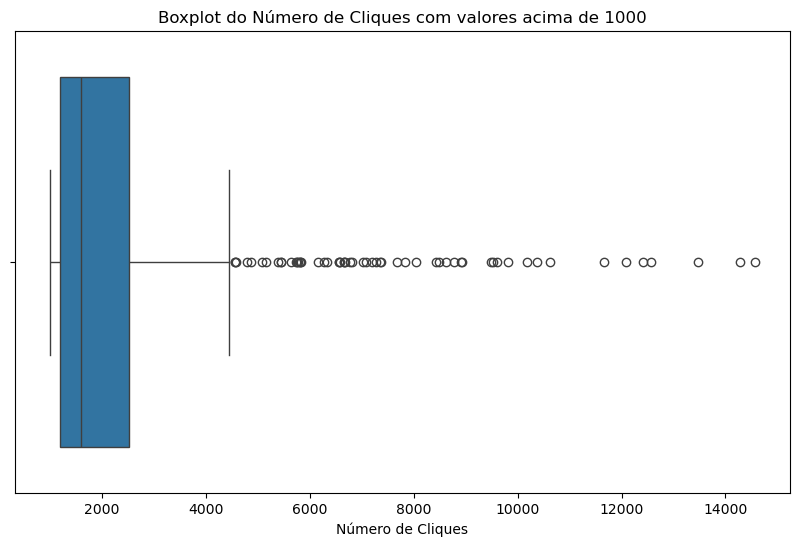

In [47]:
plt.figure(figsize=(10,6))
sns.boxplot(x=clicks_df1000['numberOfClicksHistory'])
plt.title('Boxplot do Número de Cliques com valores acima de 1000')
plt.xlabel('Número de Cliques')
plt.show()

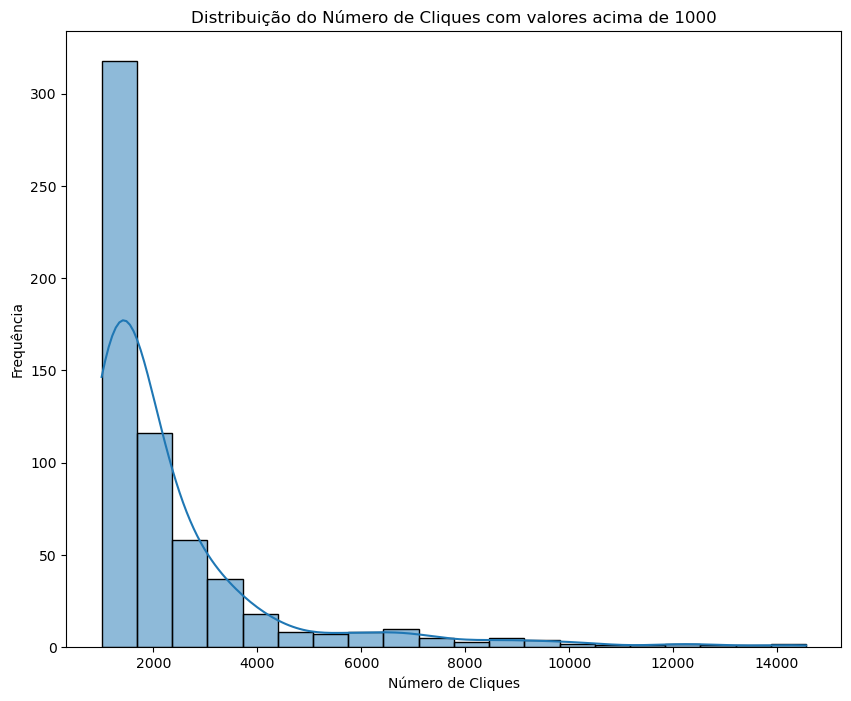

In [48]:
plt.figure(figsize=(10,8))
sns.histplot(clicks_df1000['numberOfClicksHistory'], bins=20, kde=True)
plt.title('Distribuição do Número de Cliques com valores acima de 1000')
plt.xlabel('Número de Cliques')
plt.ylabel('Frequência')
plt.show()

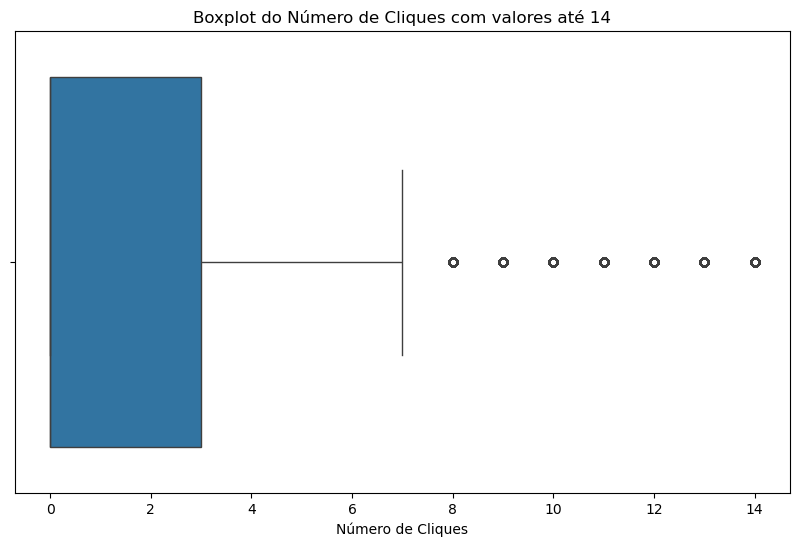

In [49]:
plt.figure(figsize=(10,6))
sns.boxplot(x=clicks_df75pct['numberOfClicksHistory'])
plt.title('Boxplot do Número de Cliques com valores até 14')
plt.xlabel('Número de Cliques')
plt.show()

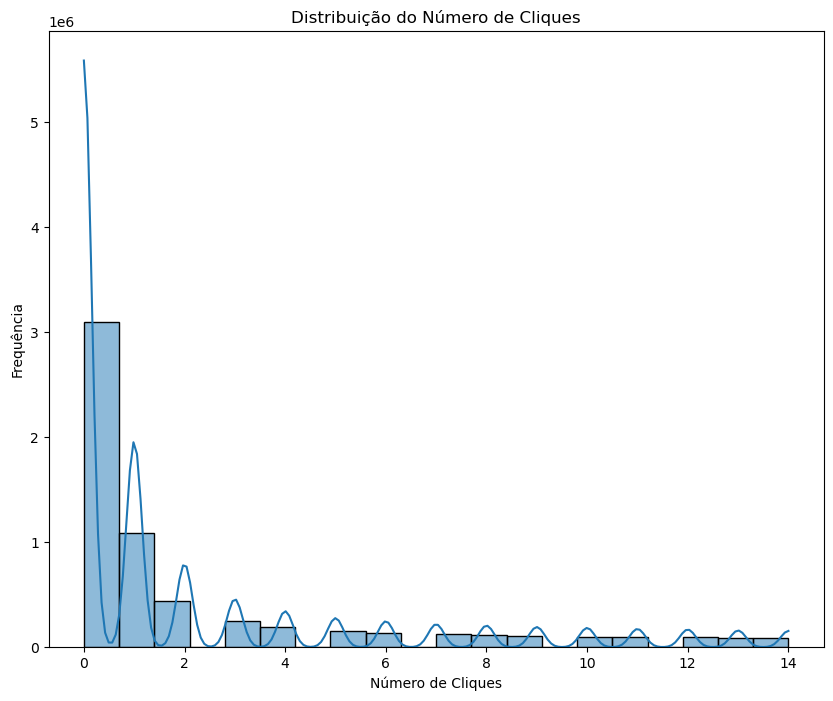

In [51]:
plt.figure(figsize=(10,8))
sns.histplot(clicks_df75pct['numberOfClicksHistory'], bins=20, kde=True)
plt.title('Distribuição do Número de Cliques')
plt.xlabel('Número de Cliques')
plt.ylabel('Frequência')
plt.show()

## Análise da porcentagem de scroll
Como identificamos valores acima de 100 no conjunto de dados, vamos separá-los em dois grupos: um contendo registros com valores de até 100 e outro com valores superiores a 100. Dessa forma, podemos analisar como esses dados estão distribuídos, considerando que a maioria dos usuários visualiza apenas um pouco mais da metade da página.

In [83]:
scroll_menor100 = logs_df.query("scrollPercentageHistory <= 100")
scroll_maior100 = logs_df.query("scrollPercentageHistory > 100")

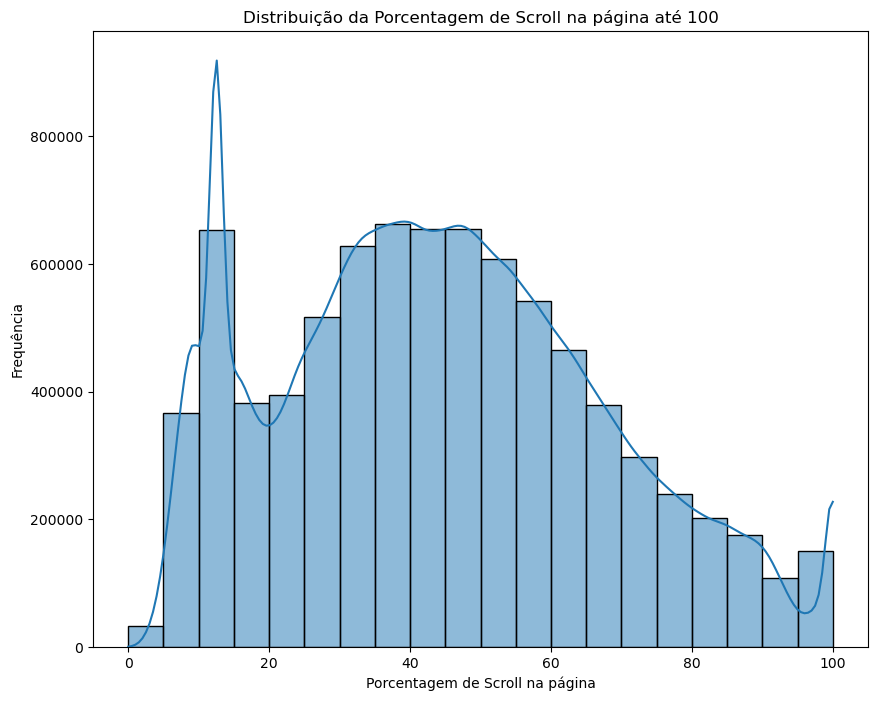

In [84]:
plt.figure(figsize=(10,8))
sns.histplot(scroll_menor100['scrollPercentageHistory'], bins=20, kde=True)
plt.title('Distribuição da Porcentagem de Scroll na página até 100')
plt.xlabel('Porcentagem de Scroll na página')
plt.ylabel('Frequência')
plt.show()

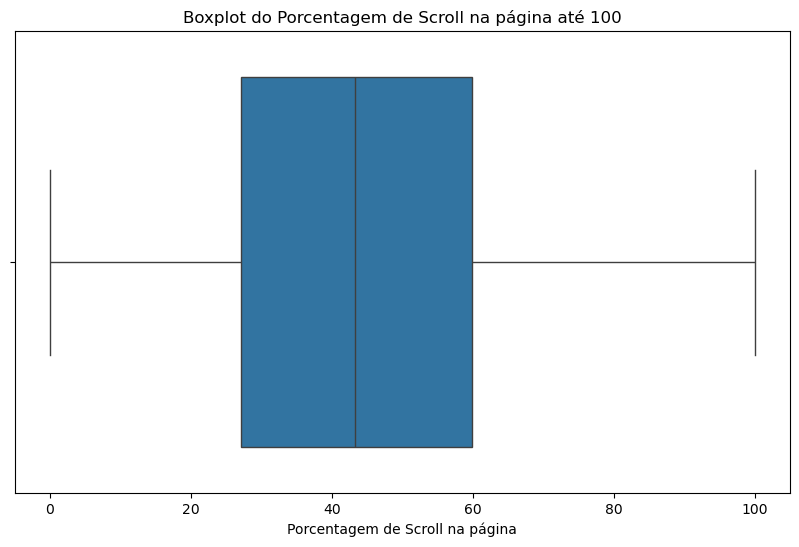

In [85]:
plt.figure(figsize=(10,6))
sns.boxplot(x=scroll_menor100['scrollPercentageHistory'])
plt.title('Boxplot do Porcentagem de Scroll na página até 100')
plt.xlabel('Porcentagem de Scroll na página')
plt.show()

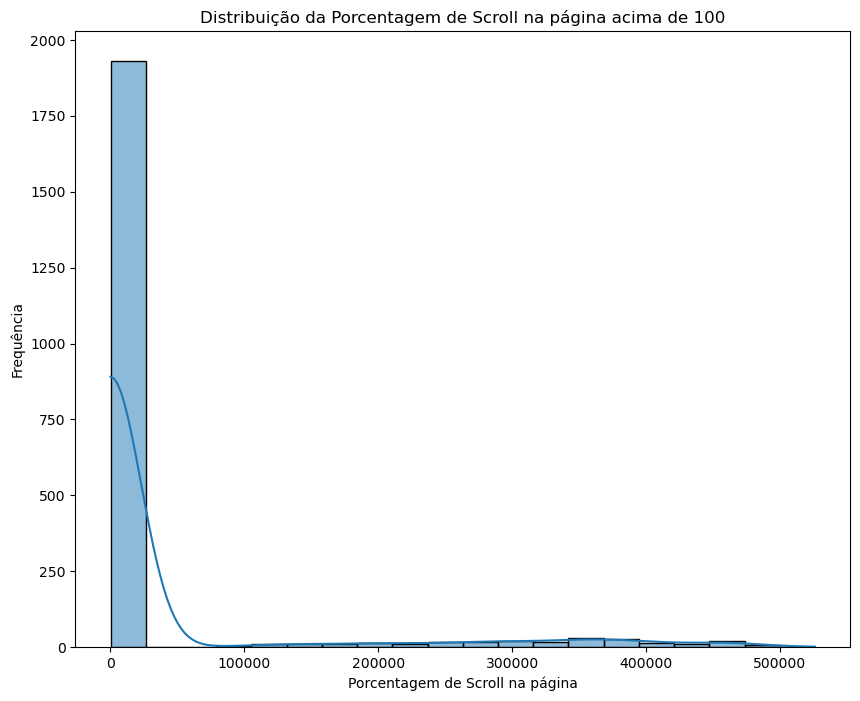

In [86]:
plt.figure(figsize=(10,8))
sns.histplot(scroll_maior100['scrollPercentageHistory'], bins=20, kde=True)
plt.title('Distribuição da Porcentagem de Scroll na página acima de 100')
plt.xlabel('Porcentagem de Scroll na página')
plt.ylabel('Frequência')
plt.show()

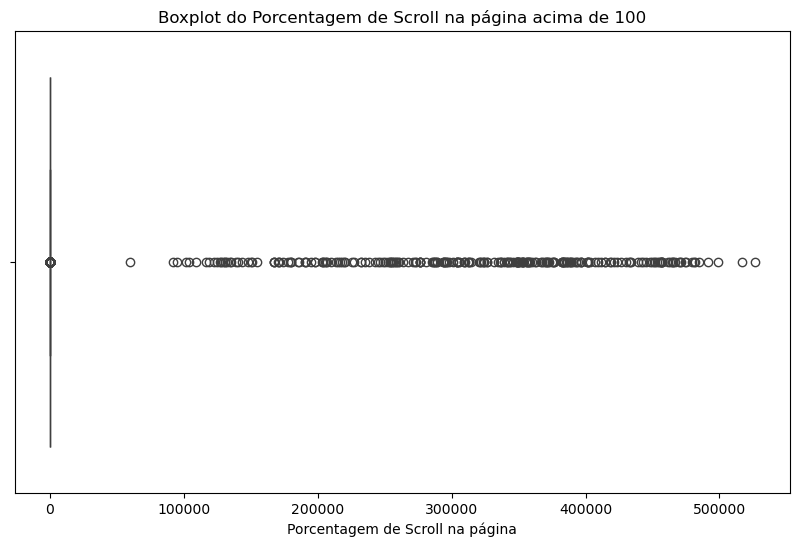

In [87]:
plt.figure(figsize=(10,6))
sns.boxplot(x=scroll_maior100['scrollPercentageHistory'])
plt.title('Boxplot do Porcentagem de Scroll na página acima de 100')
plt.xlabel('Porcentagem de Scroll na página')
plt.show()

## Análise de tempo na página
A maioria das sessões dos usuários dura cerca de 1 minuto, enquanto o valor máximo registrado é de 46.033,05 segundos, o que equivale a aproximadamente 12 horas. A seguir, analisaremos a distribuição desses tempos. Como 75% dos usuários tiveram sessões de, no máximo, cerca de 2 minutos, vamos segmentar o dataset para uma análise mais detalhada dessa distribuição.

In [101]:
tempo_2min = logs_df.query("timeOnPage_minutes < 2")
tempo_maior = logs_df.query("timeOnPage_minutes > 2")

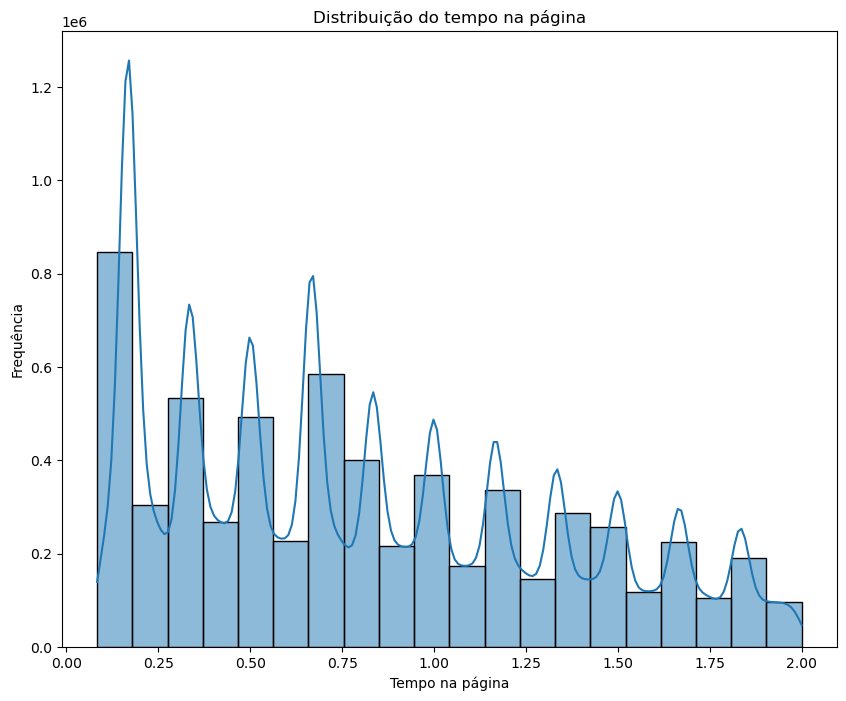

In [102]:
plt.figure(figsize=(10,8))
sns.histplot(tempo_2min['timeOnPage_minutes'], bins=20, kde=True)
plt.title('Distribuição do tempo na página')
plt.xlabel('Tempo na página')
plt.ylabel('Frequência')
plt.show()

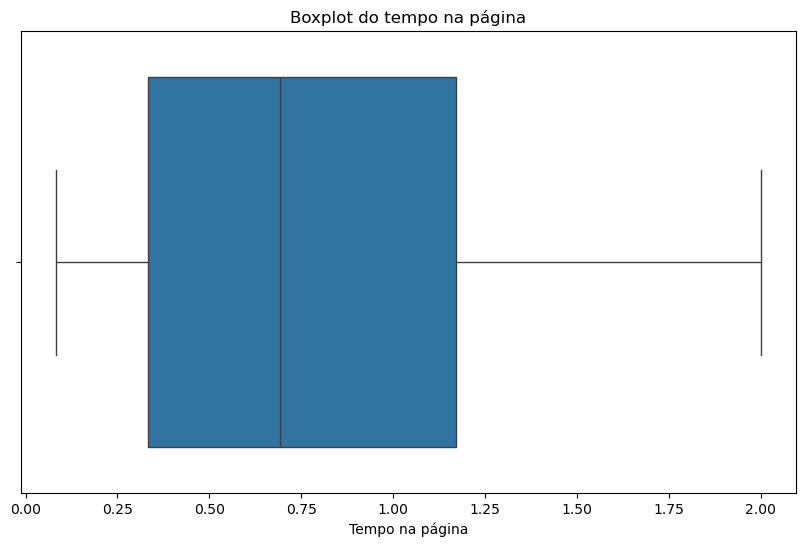

In [103]:
plt.figure(figsize=(10,6))
sns.boxplot(x=tempo_2min['timeOnPage_minutes'])
plt.title('Boxplot do tempo na página')
plt.xlabel('Tempo na página')
plt.show()

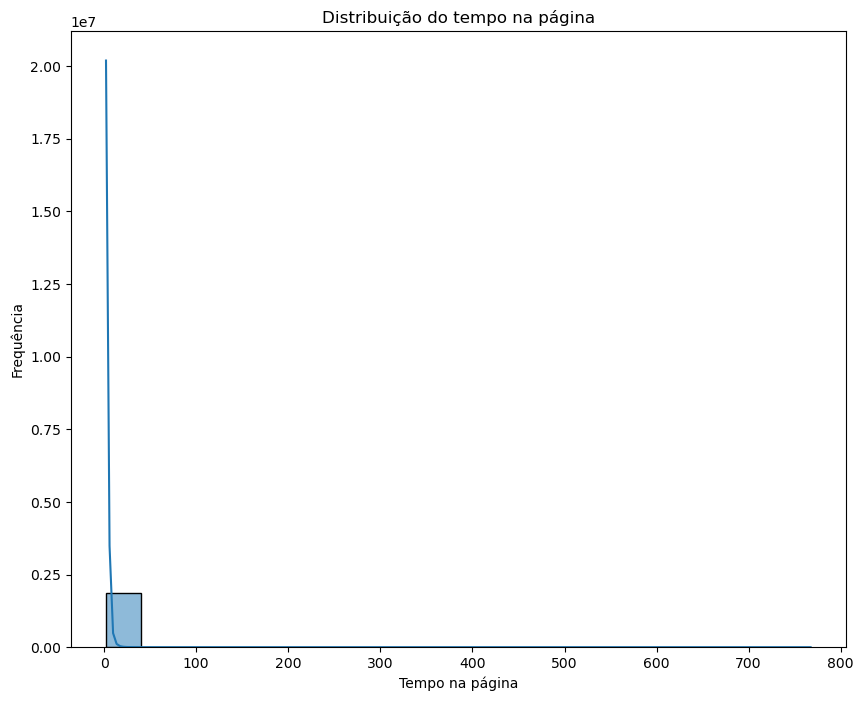

In [104]:
plt.figure(figsize=(10,8))
sns.histplot(tempo_maior['timeOnPage_minutes'], bins=20, kde=True)
plt.title('Distribuição do tempo na página')
plt.xlabel('Tempo na página')
plt.ylabel('Frequência')
plt.show()

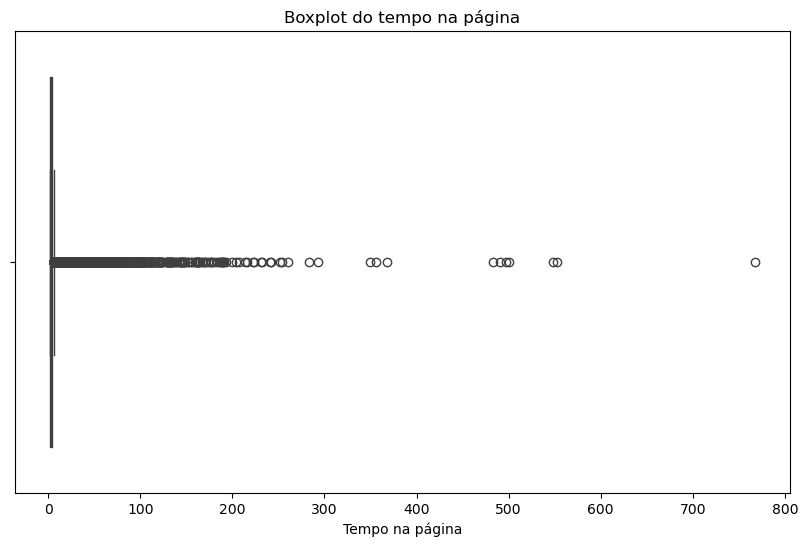

In [105]:
plt.figure(figsize=(10,6))
sns.boxplot(x=tempo_maior['timeOnPage_minutes'])
plt.title('Boxplot do tempo na página')
plt.xlabel('Tempo na página')
plt.show()

## Ajustando os valores de porcentagem
Como valores acima de 100% não fazem sentido, em vez de removê-los — o que poderia resultar na perda de dados relevantes para a recomendação do modelo — iremos substituí-los por 100%.

In [ ]:
# substituindo os valores acima de 100 no dataset
logs_df['scrollPercentageHistory'] = logs_df['scrollPercentageHistory'].apply(lambda x: 100 if x > 100 else x)

In [ ]:
# verificando a estatística descritiva depois da alteração
logs_df.describe()

,timestampHistory,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,timestampHistory_new,timeOnPage_seconds,timeOnPage_minutes
count,8123951.00,8123951.00,8123951.00,8123951.00,8123951.00,8123951.00,8123951.00,8123951.00
mean,1658636800465.51,12.05,88768.69,44.39,1.14,1658636800465.51,88.77,1.48
std,1097434547.78,37.39,113932.18,22.91,1.08,1097434547.78,113.93,1.90
min,1656644400247.00,0.00,5000.00,0.02,1.00,1656644400247.00,5.00,0.08
25%,1657674395886.50,0.00,29870.00,27.08,1.00,1657674395886.50,29.87,0.50
50%,1658676308921.00,1.00,60000.00,43.23,1.00,1658676308921.00,60.00,1.00
75%,1659579531444.00,14.00,114582.00,59.93,1.00,1659579531444.00,114.58,1.91
max,1660532387472.00,14562.00,46033049.00,100.00,654.00,1660532387472.00,46033.05,767.22


## Correlação entre os dados
Para entender melhor as relações entre as variáveis, geramos um mapa de calor da correlação entre o número de cliques, tempo na página, porcentagem de scroll e quantidade de visitas. Essa análise nos ajuda a identificar padrões e possíveis influências entre os comportamentos dos usuários no site.

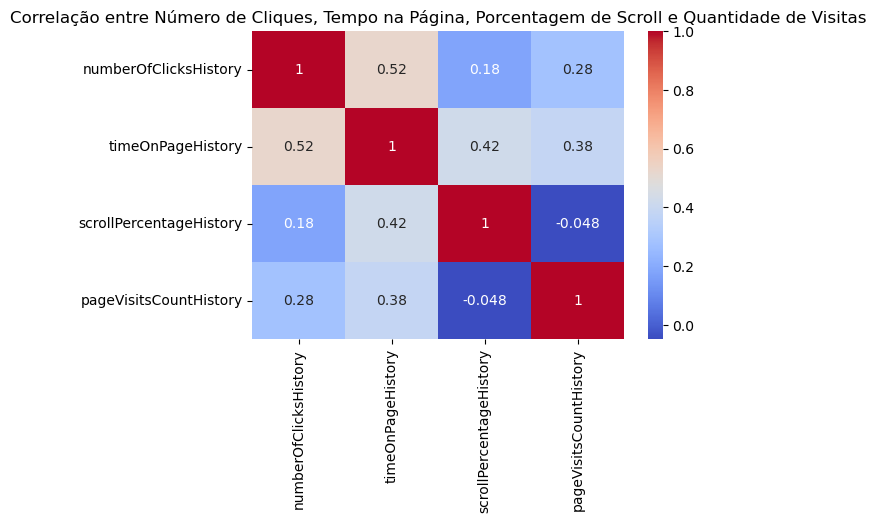

In [114]:
correlation = logs_df[['numberOfClicksHistory', 'timeOnPageHistory', 'scrollPercentageHistory', 'pageVisitsCountHistory']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlação entre Número de Cliques, Tempo na Página, Porcentagem de Scroll e Quantidade de Visitas')
plt.show()


Podemos observar que:

- Há uma correlação moderada (0.52) entre o número de cliques e o tempo na página, o que indica que, quanto mais tempo o usuário passa na página, maior a chance de ele interagir mais com os elementos clicáveis.  
- O tempo na página tem uma correlação de 0.42 com a porcentagem de scroll, sugerindo que os usuários que permanecem mais tempo tendem a percorrer mais a página.
- A quantidade de visitas apresenta uma correlação positiva (0.28) com o número de cliques e o tempo na página, indicando que usuários que retornam tendem a interagir mais.
- A porcentagem de scroll tem uma correlação muito baixa com a quantidade de visitas (-0.048), o que sugere que o comportamento de rolagem não está diretamente relacionado ao número de visitas à página.
Esses insights são importantes para entender como os usuários interagem com o conteúdo e podem ajudar na criação de estratégias para melhorar a experiência do usuário e otimizar o sistema de recomendação.

# Gráfico Pair Plot
Para visualizar melhor a distribuição das variáveis e possíveis padrões entre elas, utilizamos um Pair Plot. Esse gráfico nos permite explorar a relação entre diferentes pares de variáveis, além de mostrar a distribuição individual de cada uma. Ele é útil para identificar padrões, possíveis correlações e outliers que podem influenciar a análise e o modelo de recomendação.

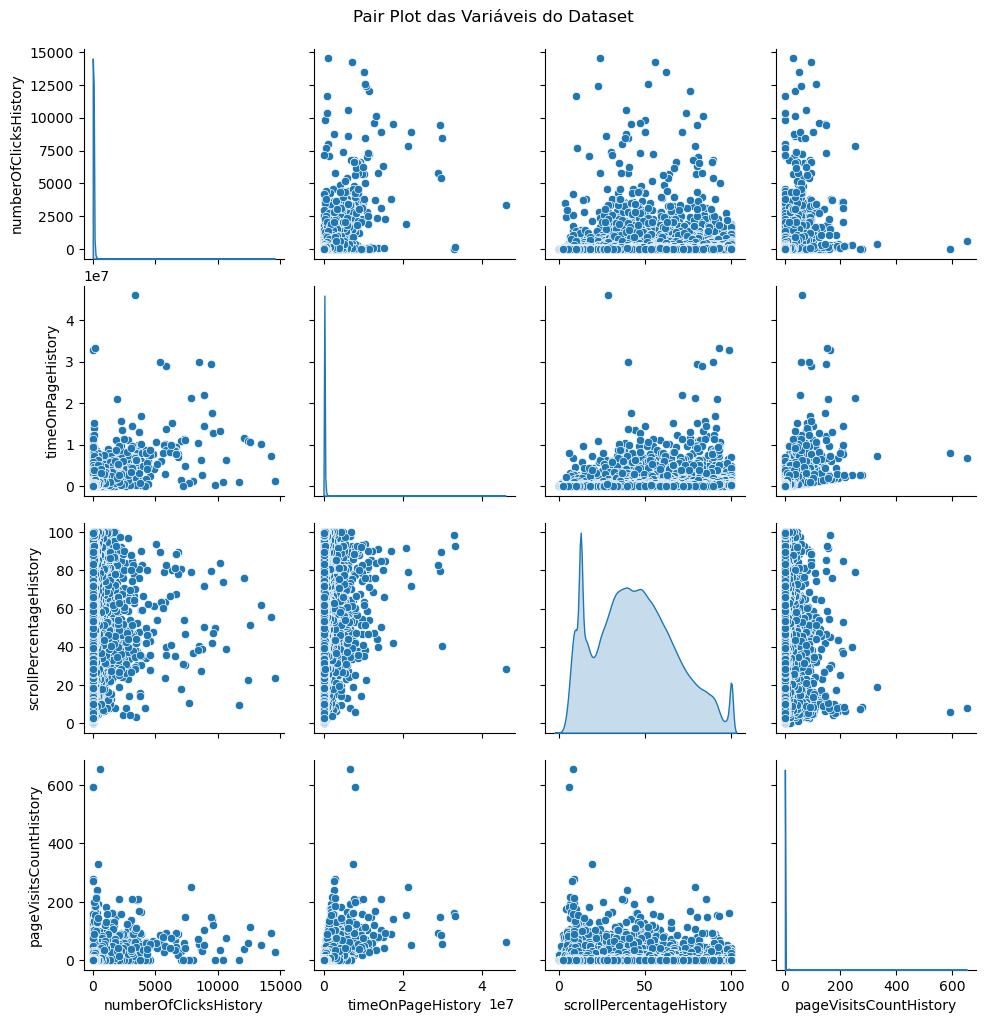

In [115]:

cols = ['numberOfClicksHistory', 'timeOnPageHistory', 'scrollPercentageHistory', 'pageVisitsCountHistory']

sns.pairplot(logs_df[cols], diag_kind='kde')  
plt.suptitle('Pair Plot das Variáveis do Dataset', y=1.02)
plt.show()


A partir do Pair Plot, podemos observar alguns pontos importantes:

- A distribuição das variáveis apresenta uma grande concentração de pontos próximos a valores baixos, sugerindo que a maioria dos usuários tem um comportamento mais restrito dentro da plataforma.
- Algumas variáveis, como número de cliques e tempo na página, apresentam uma dispersão significativa, indicando que há registros com valores extremamente altos (outliers).
- A variável porcentagem de scroll tem uma distribuição bimodal, sugerindo que existem dois grupos distintos de usuários: aqueles que percorrem pouco a página e aqueles que percorrem até o final.
- A quantidade de visitas tem muitos valores baixos, mas há casos isolados com centenas de visitas, possivelmente representando usuários frequentes ou registros anômalos.


## TD-IDF

In [ ]:
itens_df2 = pd.read_csv('./itens/itens/itens-parte2.csv')
itens_df2['issued'] = itens_df2['issued'].progress_apply(lambda x: pd.to_datetime(x).timestamp()).astype(int)
itens_df2['modified'] = itens_df2['modified'].progress_apply(lambda x: pd.to_datetime(x).timestamp()).astype(int)
itens_df2['noticia'] = itens_df2['title'] + ' ' + itens_df2['caption'] + ' ' + itens_df2['body']
itens_df2 = itens_df2.drop(['title', 'caption', 'body'], axis=1)
itens_df2.count()

In [ ]:
nlp = spacy.load("pt_core_news_sm")
def preprocessar_texto(texto):
    texto = re.sub(r'[^0-9$A-Za-z\u00C0-\u00FF ]+', '', texto)
    doc = nlp(texto)
    tokens = []

    for token in doc:
        if token.is_stop:
            continue
        token_lemma = token.lemma_.lower()
        tokens.append(token_lemma)
    return ' '.join(tokens)

In [ ]:
itens_df2['noticia'] = itens_df2['noticia'].progress_apply(preprocessar_texto)
itens_df2.to_parquet(f'processed_itens/processed_itens-parte2.parquet', engine='pyarrow', compression='snappy', index=False)

In [ ]:
itens_df = pd.concat([pd.read_parquet(arquivo) for arquivo in glob('./processed_itens/*.parquet')], ignore_index=True)

In [27]:
acessos_df = logs_df['history'].value_counts().reset_index()
acessos_df.columns = ['page', 'acessos']
acessos_df.shape

(255603, 2)

In [28]:
acessos_df.head()

,page,acessos
0,d2593c3d-2347-40d9-948c-b6065e8459a9,25075
1,f6b5d170-48b9-4f8e-88d4-c84b6668f3bd,22179
2,1f32787b-de2b-49be-8c20-ddaeae34cc22,19519
3,f0a78e58-ec7e-494c-9462-fbd6446a9a89,18361
4,6a83890a-d9e9-4f6b-a6c6-90d031785bbf,18101


In [29]:
itens_df = itens_df.merge(acessos_df, on='page', how='left')
itens_df['acessos'] = itens_df['acessos'].fillna(0)

In [30]:
itens_df.to_parquet(f'processed_itens.parquet', engine='pyarrow', compression='snappy', index=False)

In [ ]:
df_noticias = pd.read_parquet('processed_itens/processed_itens.parquet')
vectorizer = TfidfVectorizer(max_features=2000)
tfidf_matrix = vectorizer.fit_transform(df_noticias['noticia'])

with open("tfidf_vocab.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open("tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)

print("Vetorizador salvo em tfidf_vocab.pkl")
print("Matriz TF-IDF salva em tfidf_matrix.pkl")

In [24]:
df_noticias = pd.read_parquet('api/app/auxiliar/processed_itens.parquet')

with open("api/app/auxiliar/tfidf_vocab.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("api/app/auxiliar/tfidf_matrix.pkl", "rb") as f:
    tfidf_matrix = pickle.load(f)


def recomendar_noticias(noticia_input, timestamp_acesso):
    JANELA_NOTICIAS = 7 * 24 * 60 * 60
    TOP_N = 5

    timestamp_limite = timestamp_acesso - JANELA_NOTICIAS 
    df_recentes = df_noticias[(timestamp_acesso >= df_noticias['issued']) & (df_noticias['issued'] >= timestamp_limite)]
    tfidf_matrix_recentes = tfidf_matrix[df_recentes.index, :]

    input_tfidf = vectorizer.transform([noticia_input])
    similaridades = cosine_similarity(input_tfidf, tfidf_matrix_recentes).flatten()

    similar_indices_rel = similaridades.argsort()
    similar_indices_rel = similar_indices_rel[-TOP_N-1:]
    similar_indices_rel = similar_indices_rel[::-1]
    similar_indices_rel = similar_indices_rel[1:]

    indices_originais = df_recentes.index[similar_indices_rel]
    recomendacoes = pd.DataFrame({
        'noticia': df_noticias.loc[indices_originais, 'page'].values,
        'similaridade': similaridades[similar_indices_rel]
    })

    return recomendacoes

def recomendar_populares(top_n, timestamp_acesso):
    JANELA_NOTICIAS = 7 * 24 * 60 * 60

    timestamp_limite = timestamp_acesso - JANELA_NOTICIAS
    df_recentes = df_noticias[(timestamp_acesso >= df_noticias['issued']) & (df_noticias['issued'] >= timestamp_limite)]
    df_populares = df_recentes.sort_values(by='acessos', ascending=False).head(top_n)
    return df_populares['page'].head(top_n).values

def analisar_historico(id_noticias, timestamp_acesso):
    PESO_DECAIMENTO = 0.1
    TOP_N = 5

    if id_noticias == []:
        return recomendar_populares(TOP_N, timestamp_acesso)
    rank_recomendacoes = pd.DataFrame()
    for i, id_noticia in enumerate(id_noticias):
        noticia = df_noticias.loc[df_noticias['page'] == id_noticia, 'noticia'].values[0]
        recomendacoes = recomendar_noticias(noticia, timestamp_acesso)
        recomendacoes['similaridade'] = recomendacoes['similaridade'] * math.exp(-PESO_DECAIMENTO * i)
        rank_recomendacoes = pd.concat([rank_recomendacoes, recomendacoes], ignore_index=True)
    rank_recomendacoes = rank_recomendacoes.sort_values(by='similaridade', ascending=False)

    return rank_recomendacoes['noticia'].head(TOP_N).values.tolist()


### Ajuste de peso das notícias no histórico

Text(0.5, 1.0, 'Decaimento Exponencial')

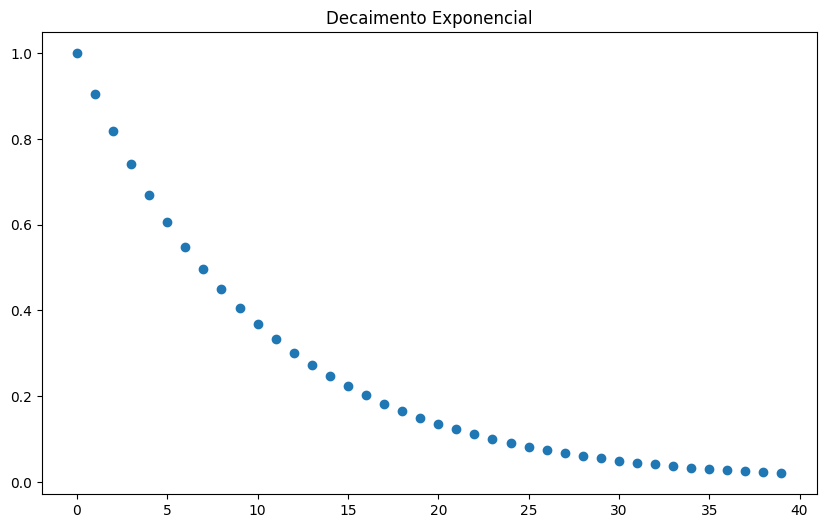

In [10]:
PESO_DECAIMENTO = 0.1
x = range(0, 40)
y = [math.exp(-PESO_DECAIMENTO * z) for z in x]

plt.figure(figsize=(10,6))
plt.scatter(x, y)
plt.title('Decaimento Exponencial')

### Exemplo de input - Função recomendar_noticias

In [4]:
x = random.randint(0, 1000)
noticia = df_noticias['noticia'].iloc[x]
timestamp = df_noticias['issued'].iloc[x]
print(timestamp)
print('Notícias acessada: ', '\n', noticia)

recomendacoes = recomendar_noticias(noticia, timestamp)

print('\n', 'Notícias recomendadas: ', '\n', recomendacoes, '\n')

for noticia in recomendacoes['noticia']:
    print(df_noticias.loc[df_noticias['page'] == noticia, 'noticia'].values[0])

1659026255
Notícias acessada:  
 estudante unb esfaquear 7 cobrar dívida amigo pânico relatar vítima 24 ano afirmar conhecer agressor haver cerca ano permitir negociar carro de ela repassar integral suspeito 18 ano solto audiência custódia estudante unb relatar esfaqueamento cobrar dívida amigo pânicouma jovem 24 ano estudante universidade brasília unb esfaquear cobrar dívida amigo crime ocorrer noite segundafeira 24 carro agressor 18 ano marcar encontro vítima pretexto pagar débitonão tô conseguir dormir pânico imagem de ele cabeça golpe emocionadaleia tambémprofessor unb acusar agredir ameaçar excompanheira 8 hora apartamentovídeo mostrar suspeito sair apartamento esfaquear namorar asa norte brasíliamarca facar jovem atacar cobrar dívida dftv globoreproduçãoà tv globo jovem contar conhecer rapaz haver cerca ano convencer deixálo negociação venda carro de ela veículo vender suspeito repassar integral vítima passar cobrar dinheiro detalhe abaixo quartafeira 27 estudante exame instituto

### Exemplo de input - Função analisar_historico

In [45]:
x = random.randint(0, treino_df.shape[0])
linha = treino_df.iloc[x]
historico = treino_df['history'].iloc[x].split(", ")
timestamp = max([int(x) for x in treino_df['timestampHistory'].iloc[x].split(", ")])//1000


print('Histórico de notícias acessadas: ')
for noticia in historico:
    print(df_noticias.loc[df_noticias['page'] == noticia, 'noticia'].values[0])

recomendacoes = analisar_historico(historico, timestamp)

print('\n', 'Notícias recomendadas: ', '\n', recomendacoes, '\n')
for noticia in recomendacoes:
    print(df_noticias.loc[df_noticias['page'] == noticia, 'noticia'].values[0])

Histórico de notícias acessadas: 
pessoa preso planejar ataque escola saquarema rj suspeitos homem 34 ano mulher 37 prisão acontecer sextafeira 6 cumprimento mandado prisão busca apreensão máscaras computador celular hds apreendir ação prender suspeito planejar ataque escola saquarema rjdivulgaçãopolícia civilum homem 34 ano mulher 37 prender madrugada sextafeira 6 saquarema região lagos rio suspeita planejar ataque escola cidadea prisão realizar policial delegacia repressão crimes informática drci cumprimento mandado prisão busca apreensão computadores máscara celular hds apreendidosde acordo polícia suspeito usar rede social criar perfis falso planejar ataque sextafeira ameaça direcionar turma educação infantila polícia civil identificar conexão acesso rastrear suspeito investigação concluír suspeito apresentar perigo real imediato sociedadedurante ação homem resistir prisão tentar tomar arma policial ser imediatamente conter equipe g1 entrar contato polícia civil crime suspeito resp

In [46]:
historico

['00d41b0b-d564-41c2-b0b9-57f150988618',
 'd6a76848-a1cb-4c1a-a0d7-ea61c52d35f5',
 'ad558a12-0ed5-4260-b2f9-ae20df39810a']

In [47]:
timestamp

1656809568

### Validação

In [ ]:
df_validacao = pd.read_csv('validacao.csv')
df_validacao = df_validacao.sample(100)

In [ ]:
def verifica_item(lista_a, lista_b):
    set_b = set(lista_b)

    for item in lista_a:
        if item in set_b:
            return True
    return False

def validar_previsao(linha):
    hist_validacao = (linha['history']
                      .replace('\n', ' ')
                      .replace("'", ' ')
                      .replace("[", ' ')
                      .replace("]", ' ')
                      .strip()
                      .split())
    
    timestamps = [int(x) for x in (linha['timestampHistory']
                                   .replace('\n', ' ')
                                   .replace("'", ' ')
                                   .replace("[", ' ')
                                   .replace("]", ' ')
                                   .strip()
                                   .split())]
    timestamp_acesso = max(timestamps) // 1000

    userId = linha['userId']
    user_hist_treino = treino_df.query(f"userId == '{userId}'")['history'].iloc[0]
    user_hist_treino = user_hist_treino.split(', ')

    previsao = analisar_historico(user_hist_treino, timestamp_acesso).tolist()
    return verifica_item(previsao, hist_validacao)


df_validacao['resultado'] = df_validacao.progress_apply(validar_previsao, axis=1)


  0%|          | 0/100 [00:00<?, ?it/s]

In [436]:
x = random.randint(0, df_validacao.shape[0]-1)
linha = df_validacao.iloc[x]
userId = linha['userId']

hist_validacao = (linha['history']
                      .replace('\n', ' ')
                      .replace("'", ' ')
                      .replace("[", ' ')
                      .replace("]", ' ')
                      .strip()
                      .split())

hist_treino = treino_df.query(f"userId == '{userId}'")['history'].iloc[0]
hist_treino = hist_treino.split(', ')

print('Notícias no histórico de treino: ', '\n')
for noticia in hist_treino:
    print(df_noticias.loc[df_noticias['page'] == noticia, 'noticia'].values[0])
print('\n')
print('Notícias no histórico de validação: ', '\n')
for noticia in hist_validacao:
    print(df_noticias.loc[df_noticias['page'] == noticia, 'noticia'].values[0])
print('\n')

Notícias no histórico de treino:  

inédito fotógrafo ensaio fervedouro água cristalina foto vídeo fazer município bodoquena ms modelo fotógrafo precisar ficar apneia encarar temperatura 18c fotógrafo ensaio modelo fervedouro inédito msinédito fotógrafo ensaio fotográfico fervedouro água cristalinasnão cearense ruver bandeira fotógrafo subaquático bonito ms realizar ensaio fotográfico água cristalina cidade entanto trabalho julho ano ruver cenário foto fervedouro inédito nascente serra bodoquena bodoquena msos registro protagonizar modelo mostrar beleza ruver contar realizar foto modelo precisar ficar apneia minutofoto fervedouro bodoquena msruver bandeiraalém dia imagem registrar fotógrafo relatar g1 ms temperatura água 18c entanto afirmar desafio valer pena resultado tirar folego mato grosso sul fotógrafo relatar objetivo registrar sucuri entanto ver julho período acasalamento espéciea ideia foto sucuri 7 metro acasalamento espécie poderíar registro convidar secretaria turismo municí

## Validação

- 10 usuários a cada 100 recebem notícias previstas no conjunto de validação;
- Notícias já visitadas podem se repetir no conjunto de validação, e o modelo não recomenda as notícias anteriores;
- Por ser um modelo baseado em contexto, caso as notícias sejam de temas inéditos, diferentes das que foram acessadas anteriormente, o modelo não as recomendará;
- Seria possível melhorar a taxa de acertos aumentando a quantidade de notícias recomendadas, assim aumentando as chances da recomendação correta estar dentre os valores.